In [3]:
%load_ext autoreload

In [4]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
from neural_analysis import spectra
import numpy as np
import os
import pickle
from sklearn.decomposition import PCA
import sys
import time 
from tqdm.notebook import tqdm

sys.path.append('..')
from utils import *
from nld_utils import *

In [5]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
dt = get_sample_interval(f, 's')
fs = 1/dt
lfp_areas = [to_string(item, f) for item in f['electrodeInfo']['area'][0]]

In [6]:
airPuff_binary, audio_binary = get_binary_stimuli(f)
stimuli = get_stimuli_start_and_end_flags(f)
get_phase_ranges(f)

{'experiment': array([[   0.   , 7085.395]]),
 'initial_phase': array([[   0.        , 1875.35996667]]),
 'loading_phase': array([[1875.35996667, 3675.35996667]]),
 'maintenance_phase': array([[3675.35996667, 5494.06313333]]),
 'unconscious_phase': array([[2315.67226667, 5618.68623333]]),
 'conscious_phase': array([[   0.        , 2315.67226667],
        [5618.68623333, 7085.395     ]]),
 'post_anesthesia_phase': array([[5494.06313333, 7085.395     ]])}

# LFP

In [10]:
# ==============
# INPUTS
# ==============

unit_index = 70
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 60
maxt = 1000

# ========
trajectory_start_steps = np.int0(trajectory_start_times/dt)
length = int(duration/dt)

results = []

for start_step in tqdm(trajectory_start_steps):
    signal_in = f['lfp'][unit_index, start_step:start_step + length]
    ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
    ret['signal'] = signal_in
    ret['airPuff'] = airPuff_binary[start_step:start_step + length]
    ret['audio'] = audio_binary[start_step:start_step + length]
    ret['start_step'] = start_step
    
    results.append(ret)

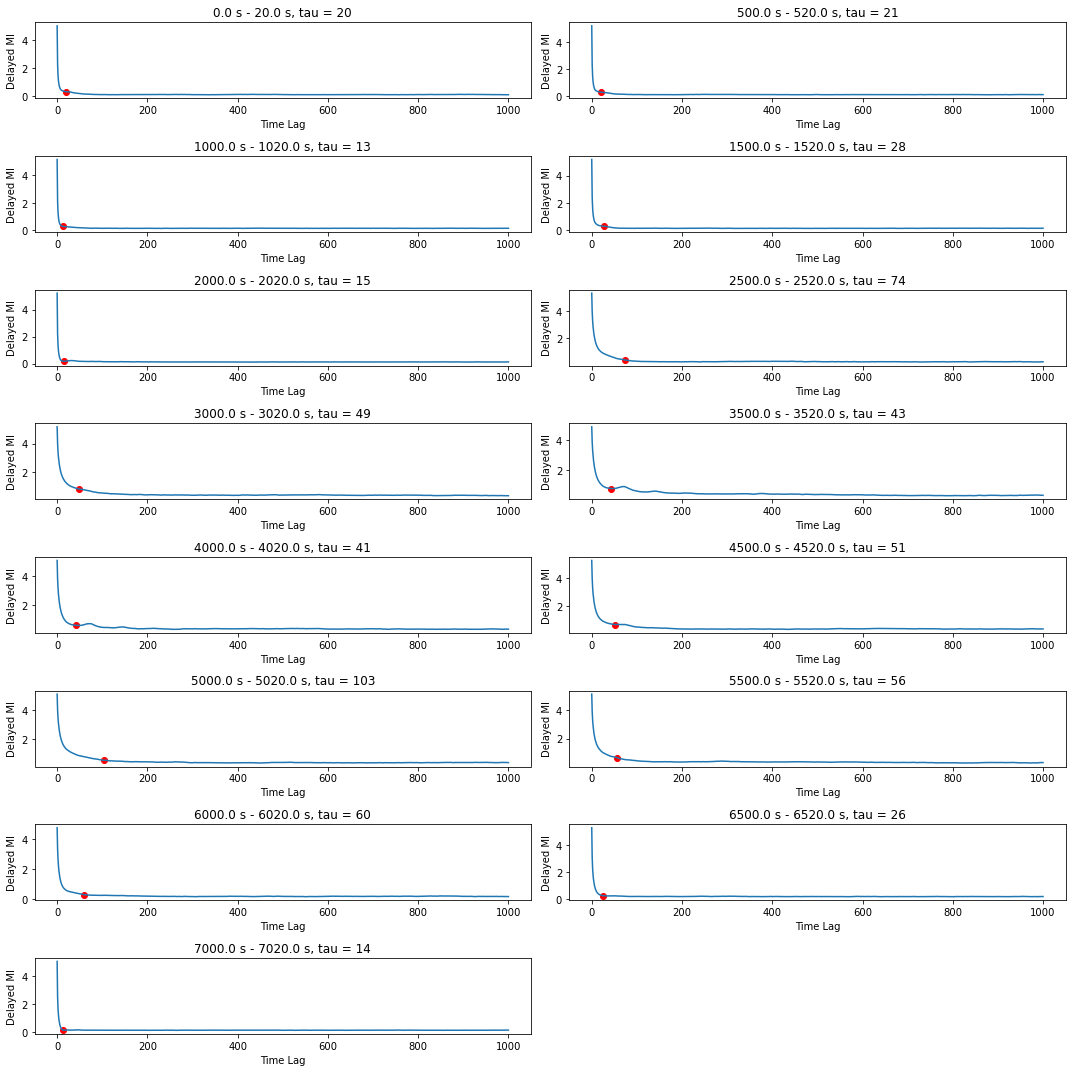

In [11]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['delayed_mi'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, tau = {ret['tau']}")
    plt.scatter(ret['tau'], ret['delayed_mi'][ret['tau']], c='red')
    plt.xlabel(r'Time Lag')
    plt.ylabel(r'Delayed MI')
plt.tight_layout()
plt.show()

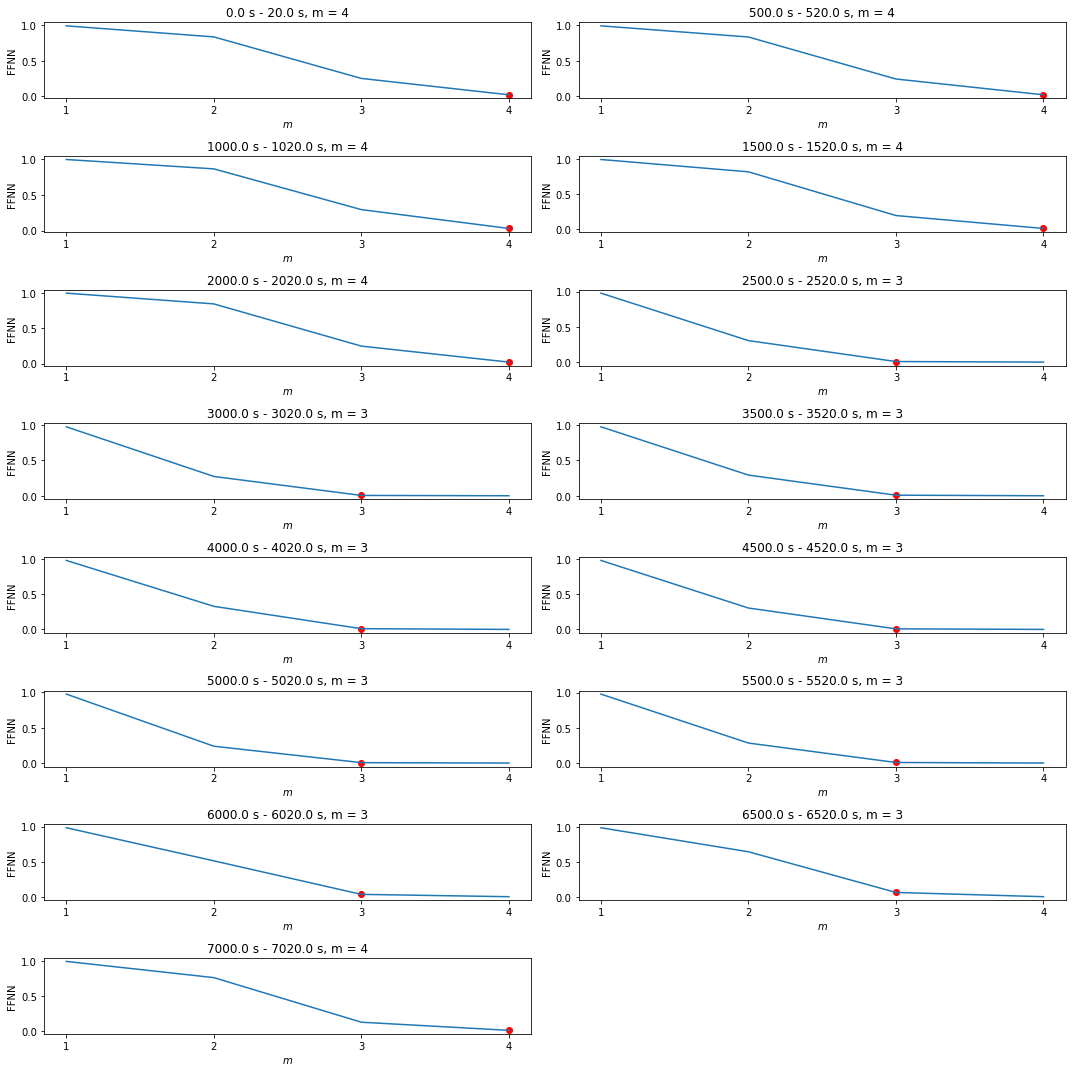

In [12]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, m = {ret['m']}")
    plt.scatter(ret['m'], ret['fraction_fnn'][ret['m'] - 1], c='red')
    plt.xticks(ret['m_vals'], ret['m_vals'])
    plt.xlabel(r'$m$')
    plt.ylabel(r'FFNN')
plt.tight_layout()
plt.show()

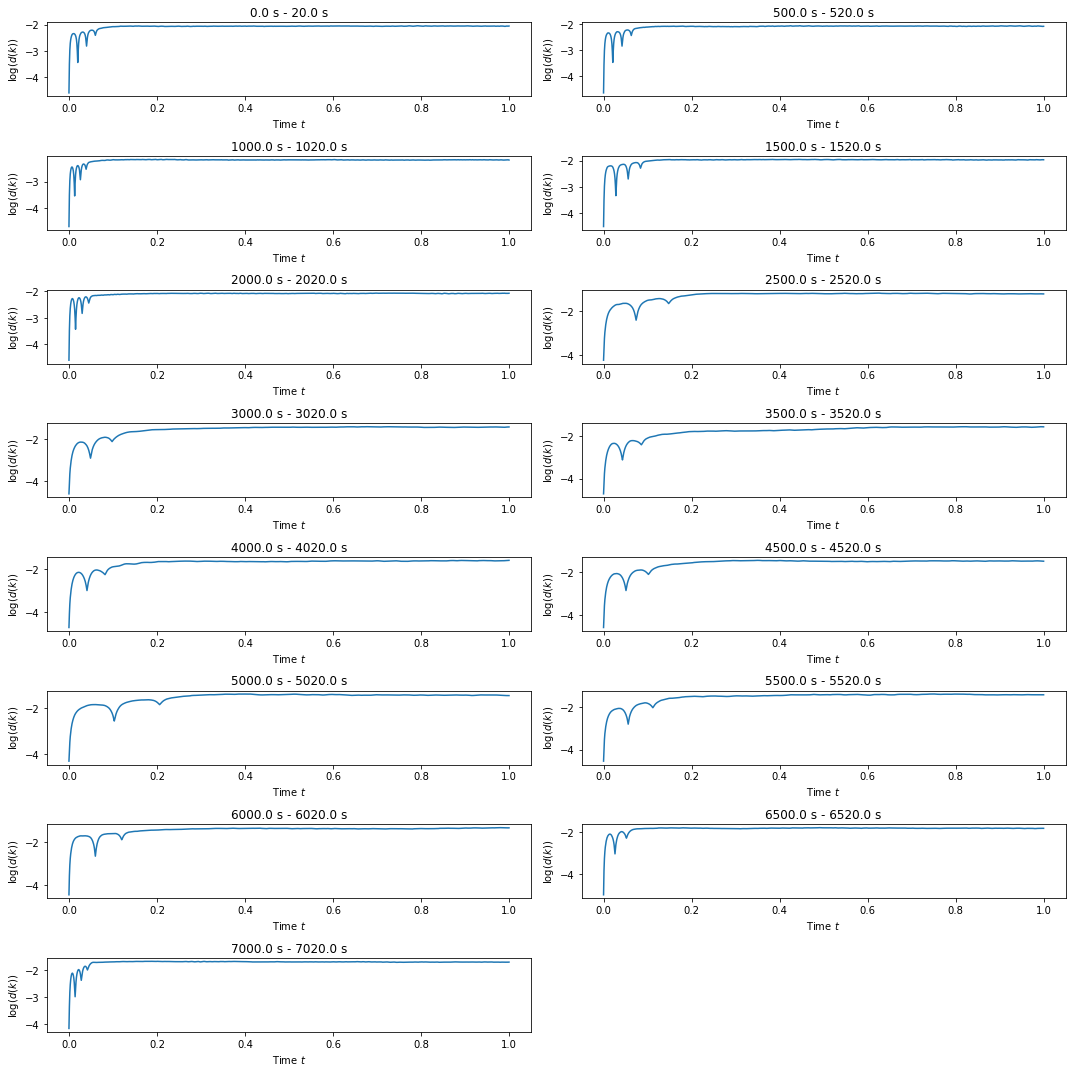

In [14]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    ret['t'] = np.arange(len(ret['d']))
    plt.plot(ret['t']*dt, ret['d'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s")
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'log($d(k)$)')
plt.tight_layout()
plt.show()

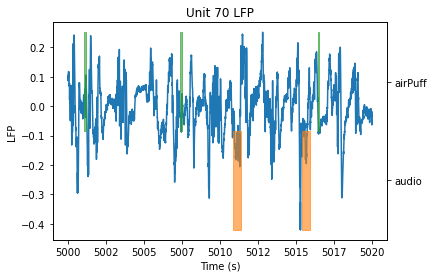

In [20]:
ret = results[10]
plt.plot(ret['signal'])
ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(np.arange(len(ret['signal'])), 0, 1, where=ret['airPuff'], color='C2', alpha=0.6)
ax2.fill_between(np.arange(len(ret['signal'])), -1, 0, where=ret['audio'], color='C1', alpha=0.6)
ax2.set_yticks([-0.5, 0.5])
ax2.set_yticklabels(['audio', 'airPuff'])
ax.set_ylabel('LFP')
plt.title(f'Unit {unit_index} LFP')
xticklocs = plt.xticks()[0][1:-1]
plt.xticks(xticklocs, [int(loc*dt + ret['start_step']*dt) for loc in xticklocs])
ax.set_xlabel('Time (s)')
plt.show()

# Firing Rates

In [21]:
# firing rate params
window = 250
stride = 25

In [23]:
# compute firing rates or load
filename = ''.join([data_path[:-4], f'_vlPFC_fr_window_{window}_stride_{stride}.pkl'])

if os.path.exists(filename):
    with open(filename, 'rb') as handle:
        fr_dict = pickle.load(handle)
    vlPFC_fr = fr_dict['vlPFC_fr']
    bins = fr_dict['bins']
else:
    test_duration = get_test_duration(f)

    vlPFC_fr = None
    for unit_index in tqdm(range(248)):
        if to_string(f[f['unitInfo']['area'][0, unit_index]]) == "vlPFC":
            fr, bins = spike_times_to_firing_rate(get_unit_spikes(unit_index, f)['spike_times'], window=window, stride=stride, test_duration=test_duration, progress_bar=False)
            if vlPFC_fr is None:
                vlPFC_fr = fr
            else:
                vlPFC_fr = np.vstack([vlPFC_fr, fr])
    with open(filename, 'wb') as handle:
        pickle.dump({'vlPFC_fr': vlPFC_fr, 'bins': bins}, handle)

In [40]:
# # ==============
# INPUTS
# ==============

unit_index = 0
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 60
maxt = 500


# ========

length = int(duration*1000)
results_fr = []

for start_time in tqdm(trajectory_start_times):
    start_step = int(start_time*1000)
    start_bin = np.argmax(bins > start_time)
    end_bin = np.argmax(bins > start_time + duration)
    fr_PCA = PCA().fit_transform(vlPFC_fr.T[start_bin:end_bin])
    signal_in = fr_PCA[:, 0]
    ret = lyapunov_analysis(signal_in, nlags=min(int(len(signal_in)/2), 1000), max_m=10, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
    ret['signal'] = signal_in
    ret['airPuff'] = [airPuff_binary[int(bins[b]*fs):int(bins[b]*fs) + window].sum() > 0 for b in np.arange(start_bin, end_bin)]
    ret['audio'] = [audio_binary[int(bins[b]*fs):int(bins[b]*fs) + window].sum() > 0 for b in np.arange(start_bin, end_bin)]
    ret['start_step'] = start_step
    ret['start_time'] = start_time
    ret['start_bin'] = start_bin
    ret['end_bin'] = end_bin
    
    results_fr.append(ret)

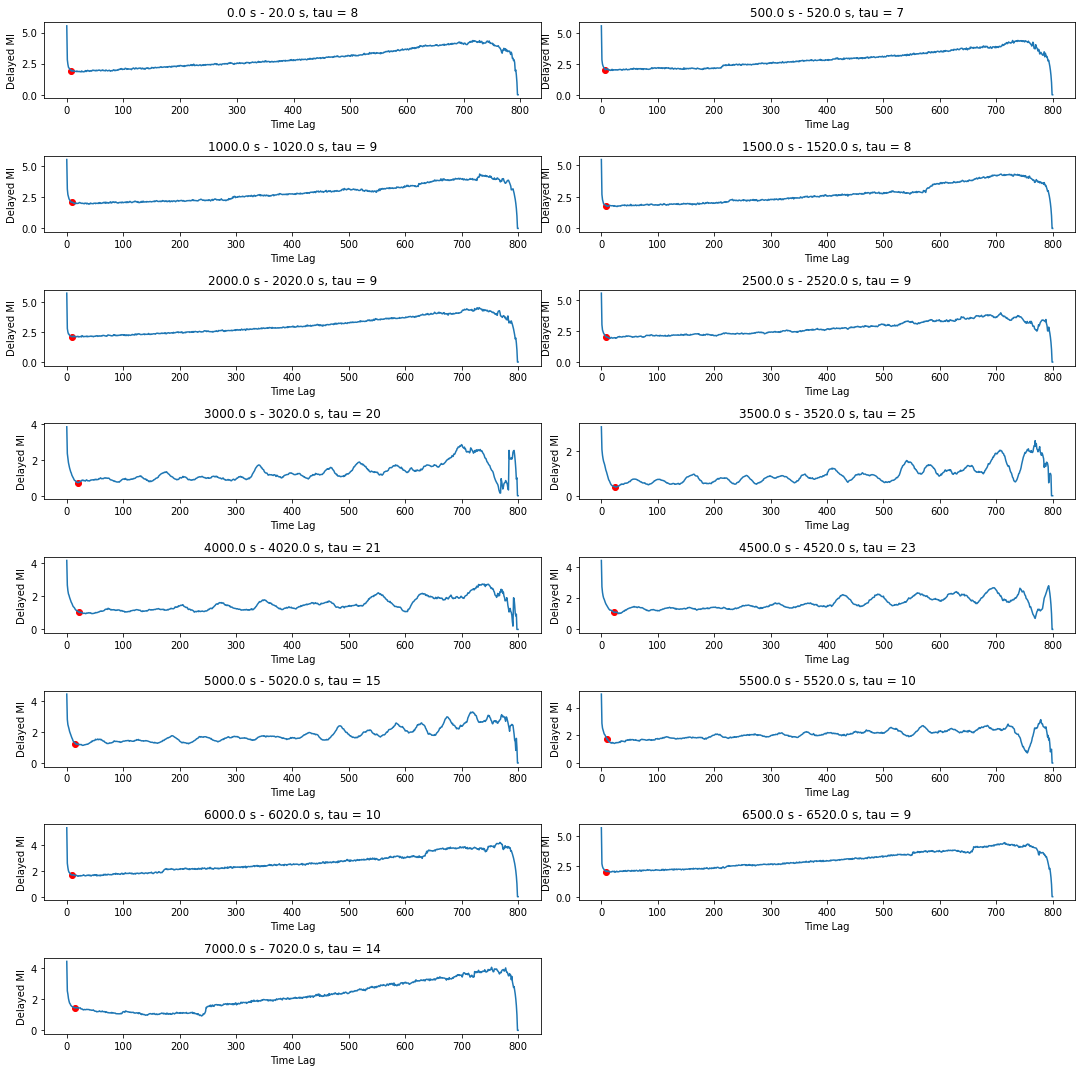

In [41]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['delayed_mi'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, tau = {ret['tau']}")
    plt.scatter(ret['tau'], ret['delayed_mi'][ret['tau']], c='red')
    plt.xlabel(r'Time Lag')
    plt.ylabel(r'Delayed MI')
plt.tight_layout()
plt.show()

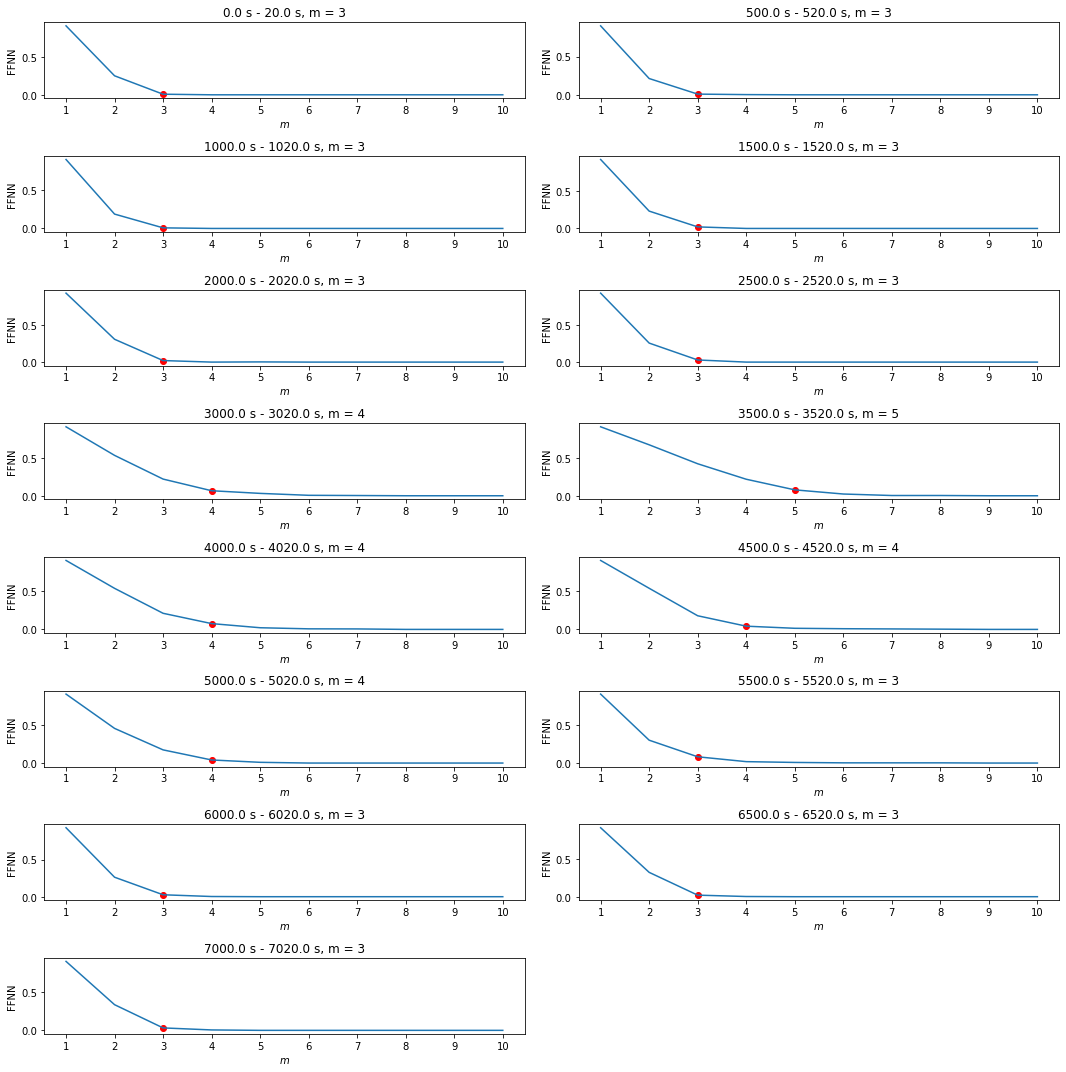

In [42]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, m = {ret['m']}")
    plt.scatter(ret['m'], ret['fraction_fnn'][ret['m'] - 1], c='red')
    plt.xticks(ret['m_vals'], ret['m_vals'])
    plt.xlabel(r'$m$')
    plt.ylabel(r'FFNN')
plt.tight_layout()
plt.show()

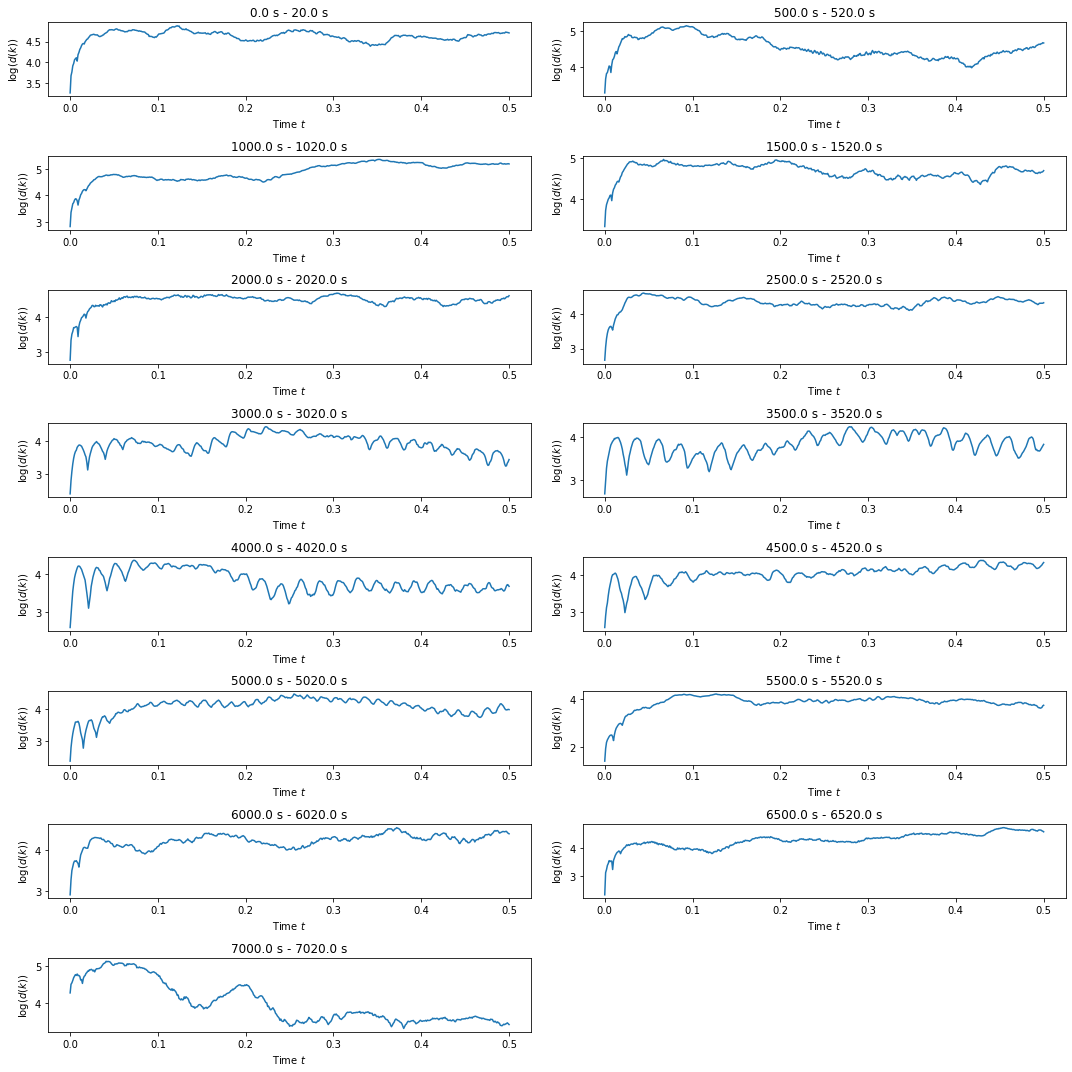

In [43]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    ret['t'] = np.arange(len(ret['d']))
    plt.plot(ret['t']*dt, ret['d'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s")
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'log($d(k)$)')
plt.tight_layout()
plt.show()

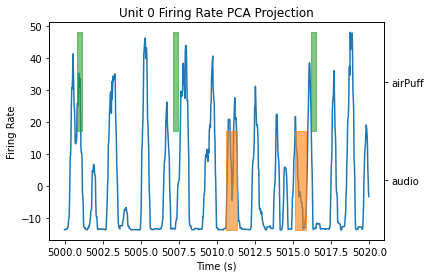

In [50]:
ret = results_fr[10]
plt.plot(ret['signal'])
ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(np.arange(len(ret['signal'])), 0, 1, where=ret['airPuff'], color='C2', alpha=0.6)
ax2.fill_between(np.arange(len(ret['signal'])), -1, 0, where=ret['audio'], color='C1', alpha=0.6)
ax2.set_yticks([-0.5, 0.5])
ax2.set_yticklabels(['audio', 'airPuff'])
ax.set_ylabel('Firing Rate')
plt.title(f'Unit {unit_index} Firing Rate PCA Projection')
xticklocs = plt.xticks()[0][1:-1]
plt.xticks(xticklocs, [loc*stride*dt + ret['start_time'] for loc in xticklocs])
ax.set_xlabel('Time (s)')
plt.show()

# Power Spectra

In [7]:
lfp_areas[180]

'CPB'

In [8]:
# ==============
# INPUTS
# ==============

# LFP ARGS

unit_index = 70
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

# SPECTROGRAM ARGS

spectrogram_kwargs = dict(
    method='multitaper',
    spec_type='power',
    time_width=0.25,
    freq_width=4,
    spacing=0.05,
    freq_range=[0, 80],
)

bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

#  NLD ARGS

p = 1
r = 10
theiler_window = 60 # ms
maxt = 100

# ========
trajectory_start_steps = np.int0(trajectory_start_times/dt)
length = int(duration/dt)

results_pow = {}
for band in bands:
    results_pow[band] = []

    
iterator = tqdm(total=len(trajectory_start_steps)*len(bands)) 
for start_step in trajectory_start_steps: 
    lfp_signal = f['lfp'][unit_index, start_step:start_step + length]
    spec, freq, timepts = spectra.spectrogram(lfp_signal, fs, **spectrogram_kwargs)
    freq_band_power = dict(
        delta=spec[np.logical_and(freq > 0, freq <= 4)].sum(0),
        theta=spec[np.logical_and(freq > 4, freq <= 8)].sum(0),
        alpha=spec[np.logical_and(freq > 8, freq <= 12)].sum(0),
        beta=spec[np.logical_and(freq > 12, freq <= 30)].sum(0),
        gamma=spec[np.logical_and(freq > 30, freq <= 80)].sum(0),
    )
    for band in bands:
        signal_in = freq_band_power[band]
        ret = lyapunov_analysis(signal_in, nlags=min(1000, len(signal_in)), max_m=10, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
        ret['signal'] = signal_in
        ret['airPuff'] = [airPuff_binary[start_step + int(timepts[i]*fs):start_step + int(timepts[i]*fs) + int(spectrogram_kwargs['time_width']*fs)].sum() > 0 for i in np.arange(len(timepts))]
        ret['audio'] = [audio_binary[start_step + int(timepts[i]*fs):start_step + int(timepts[i]*fs) + int(spectrogram_kwargs['time_width']*fs)].sum() > 0 for i in np.arange(len(timepts))]
        ret['start_step'] = start_step
        ret['band'] = band
        ret['freq_band_power'] = freq_band_power
    
        results_pow[band].append(ret)
    
        iterator.update()
iterator.close()

In [9]:
band = 'gamma'

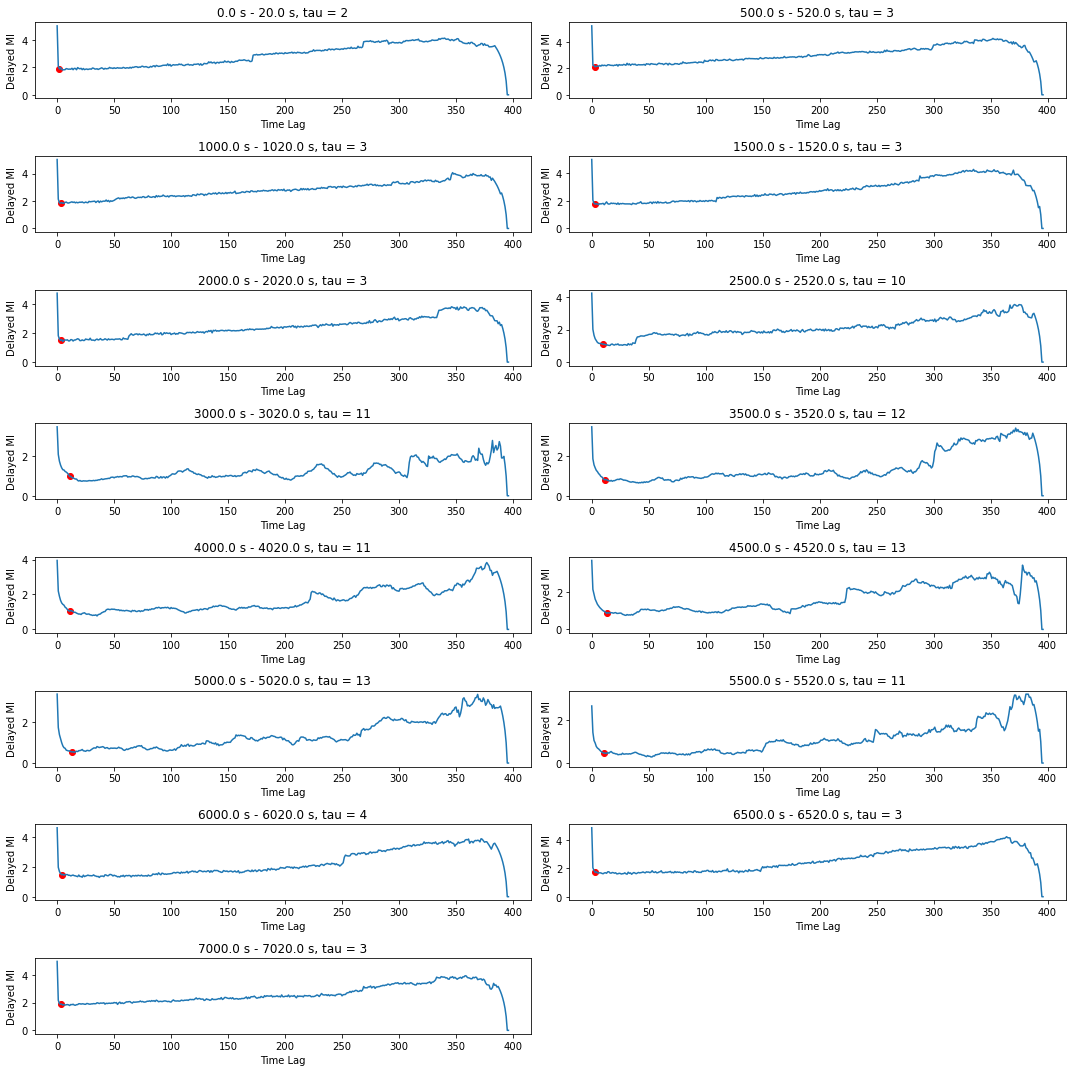

In [10]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_pow[band]):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['delayed_mi'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, tau = {ret['tau']}")
    plt.scatter(ret['tau'], ret['delayed_mi'][ret['tau']], c='red')
    plt.xlabel(r'Time Lag')
    plt.ylabel(r'Delayed MI')
plt.tight_layout()
plt.show()

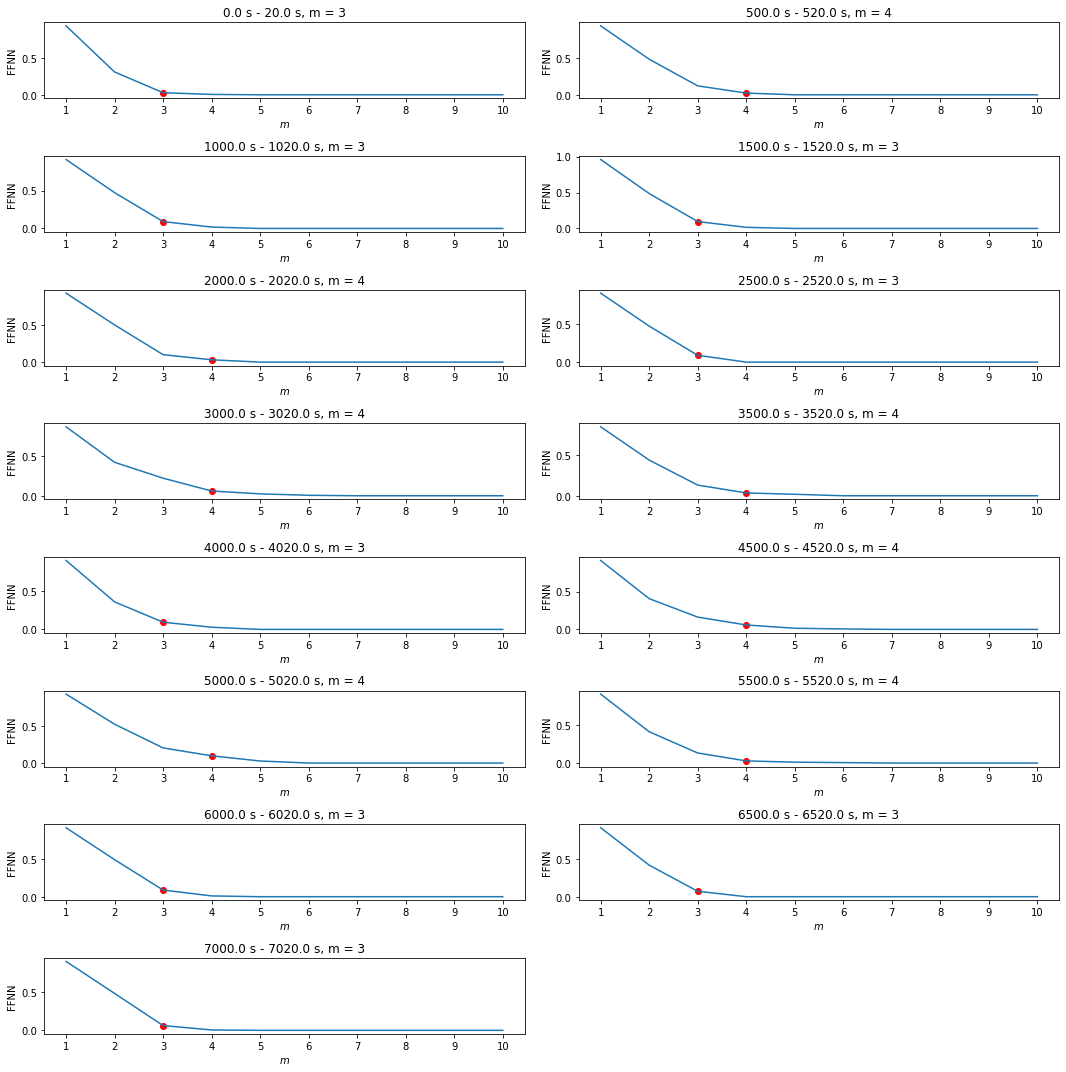

In [12]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_pow[band]):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, m = {ret['m']}")
    plt.scatter(ret['m'], ret['fraction_fnn'][ret['m'] - 1], c='red')
    plt.xticks(ret['m_vals'], ret['m_vals'])
    plt.xlabel(r'$m$')
    plt.ylabel(r'FFNN')
plt.tight_layout()
plt.show()

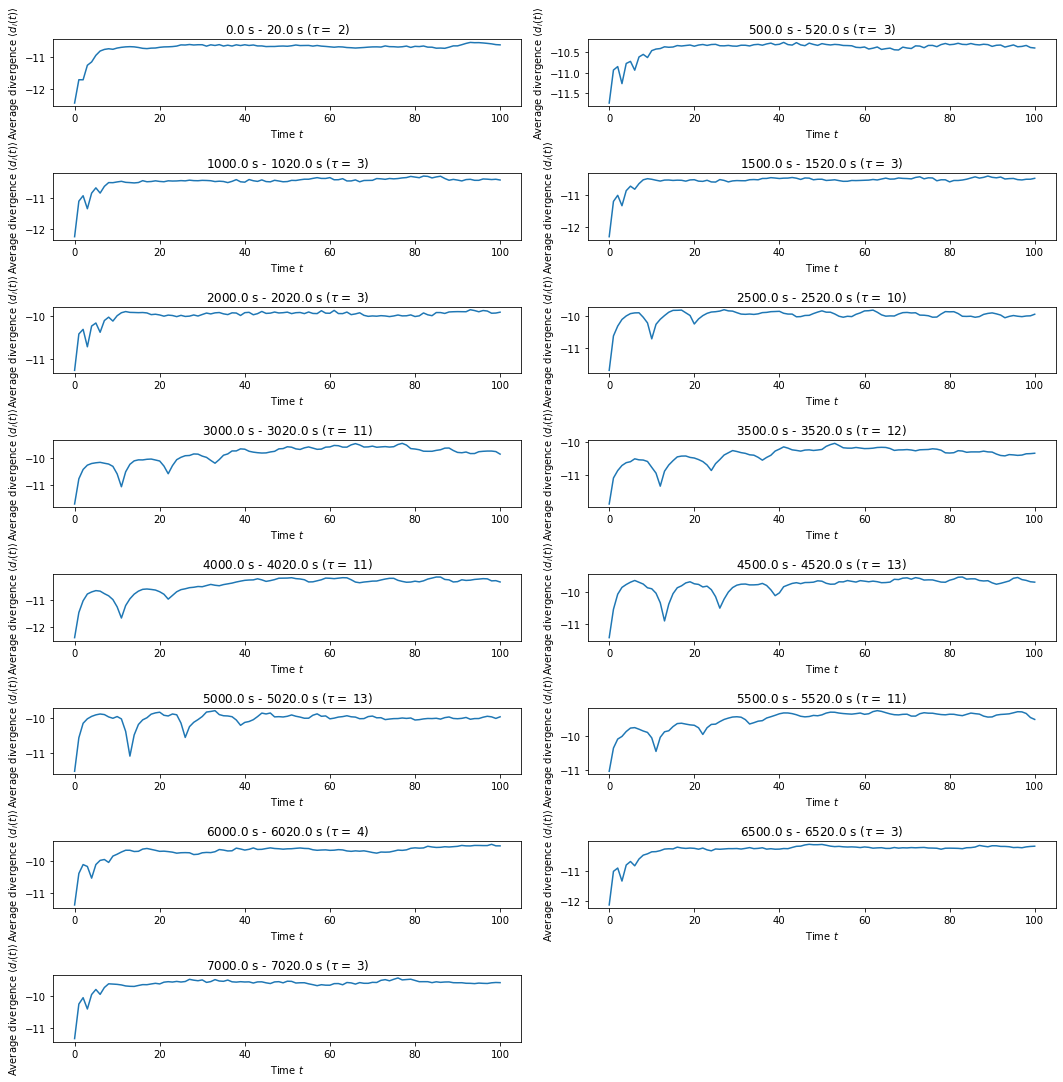

In [14]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_pow[band]):
    plt.subplot(8, 2, i + 1)
    ret['t'] = np.arange(len(ret['d']))
    plt.plot(ret['t'], ret['d'])
    plt.title(fr"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s ($\tau = $ {ret['tau']})")
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

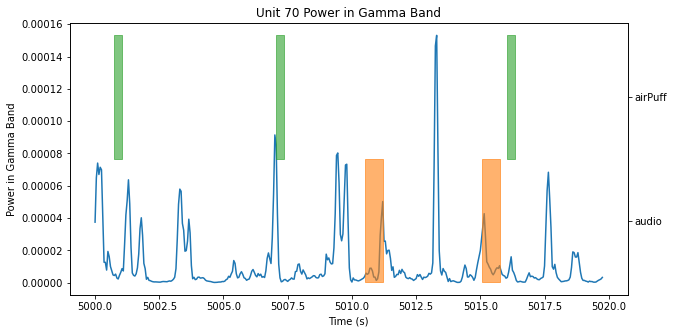

In [73]:
ret = results_pow[band][10]
plt.figure(figsize=(10, 5))
plt.plot(ret['signal'])
ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(np.arange(len(ret['signal'])), 0, 1, where=ret['airPuff'], color='C2', alpha=0.6)
ax2.fill_between(np.arange(len(ret['signal'])), -1, 0, where=ret['audio'], color='C1', alpha=0.6)
ax2.set_yticks([-0.5, 0.5])
ax2.set_yticklabels(['audio', 'airPuff'])
ax.set_ylabel(f'Power in {band.capitalize()} Band')
plt.title(f'Unit {unit_index} Power in {band.capitalize()} Band')
xticklocs = plt.xticks()[0][1:-1]
plt.xticks(xticklocs, [loc*spectrogram_kwargs['spacing'] + ret['start_step']*dt for loc in xticklocs])
ax.set_xlabel('Time (s)')
plt.show()